## add guassian noise to the image

From $\boldsymbol{x}_{t-1}$ to $\boldsymbol{x}_t$, we can add some noise to the image. The noise is generated by the following equation:
$$\boldsymbol{x}_t = \sqrt{\alpha_t} \boldsymbol{x}_{t-1} + \sqrt{1-\alpha_t} \boldsymbol{\varepsilon}_t, \quad \boldsymbol{\varepsilon}_t \sim \mathcal{N}(\mathbf{0}, \mathbf{I})$$


also it's not hard to prove that from $\boldsymbol{x}_{0}$ to $\boldsymbol{x}_t$, we can also use the following equation to generate the noise:
$$\boldsymbol{x}_t =\sqrt{ \bar{\alpha}_t} \boldsymbol{x}_0 + \sqrt{1- \bar{\alpha}_t}\bar{\boldsymbol{\varepsilon}}_t, \quad \bar{\boldsymbol{\varepsilon}}_t \sim \mathcal{N}(\mathbf{0}, \mathbf{I}), \quad  \bar{\alpha}_t=\prod_{i=1}^t \alpha_i$$

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.0028915652..0.9767912].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.0059363693..0.97569734].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.015153309..0.9852215].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.298032..1.3181938].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.0395243..2.588649].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-3.8858306..3.7431893].


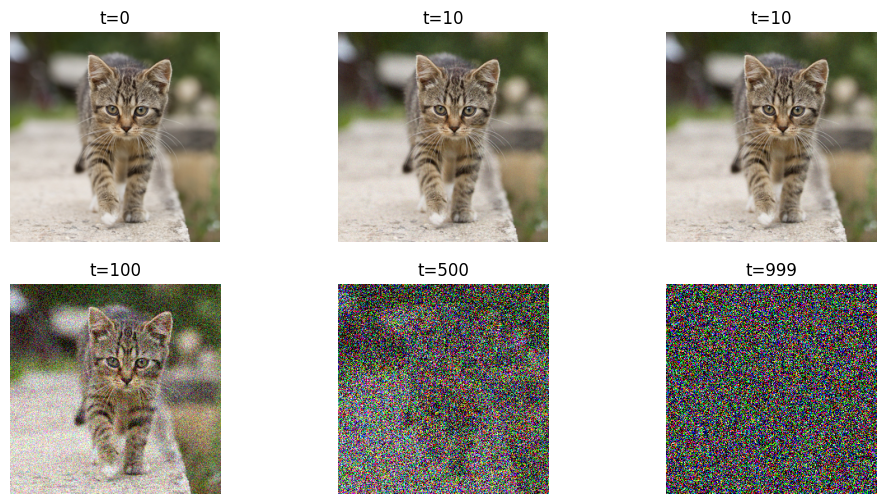

In [55]:
import torch
from PIL import Image 
import numpy as np
import matplotlib.pyplot as plt
from einops import rearrange 

T = 1000

beta = 0.005 * torch.arange(1, T + 1) / T
alpha = 1 - beta
bar_alpha = torch.cumprod(alpha, 0)
sqrt_bar_alpha = torch.sqrt(bar_alpha)
sqrt_bar_beta = torch.sqrt(1 - sqrt_bar_alpha)


def sample_x(x_0, t, bar_alpha, bar_beta, noise=None):
    if not noise: noise = torch.randn_like(x_0)
    shape = (x_0.shape[0], 1, 1, 1)
    return x_0 * bar_alpha[t].view(shape) + noise * bar_beta[t].view(shape), noise

## read image 
img = Image.open("./tiger_cat.jpg")
img = img.resize((256, 256))
img = torch.tensor(np.array(img)).permute(2, 0, 1).float() / 255
img = rearrange(img, 'c h w -> () c h w')

t_list = [0, 10, 10, 100, 500, 999]

x_list = []
for t in t_list:
    x, noise = sample_x(img, t, bar_alpha, sqrt_bar_beta)
    x_list.append(x)

x_list = torch.cat(x_list, 0)
x_list = rearrange(x_list, 't c h w -> t h w c')

plt.figure(figsize=(12, 6))
for i, t in enumerate(t_list):
    plt.subplot(2, 3, i + 1)
    plt.imshow(x_list[i])
    plt.title(f"t={t}")
    plt.axis("off")
plt.show()

